# Prognoza pogody

## Określenie celów, zrozumienie problemu.

Naszym celem będzie stworzenie prognozy pogody na 24 godziny w przód w Jena w Niemczech. 

Ustalamy trzy okresy czasu, 1 dzień, 3 dni i 5 dni, na podstawie których stworzone przez nas modele będą szacować parametry pogodowe w naszej prognozie.

Zbadamy następujące modele: 'Dense', 'Convolution neural network' i 'Recurrent neural network'.

Dzięki danym testowym ocenimy, który model jest najlepszy i przy jego użyciu przeprowadzimy prognozę pogody 01 stycznia 2017 roku.

Jeżeli nie posiadasz zainstalowanych pakietów dobrze je zainstalować już teraz. 


In [1]:
import os
from zipfile import ZipFile
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-02-20 09:40:57.639385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 09:41:00.538142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 09:41:00.538166: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 09:41:04.826544: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [3]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


## Zrozumienie danych.

Jak możemy zauważyć posiadamy 420551 wierszy i 15 kolumn. Dla lepszego oglądu oglądamy wykresy i sprawdzamy parametry naszych danych. 

Typ danych

In [5]:
df.dtypes

p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

Czy istnieją nulle w danych

In [6]:
df.apply(pd.isnull).sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

Czy istnieją duplikaty

In [7]:
df.duplicated(keep='first').sum()

329

Usuwamy duplikaty

In [8]:
df = df.drop_duplicates(keep='first')
df.duplicated(keep='first').sum()

0

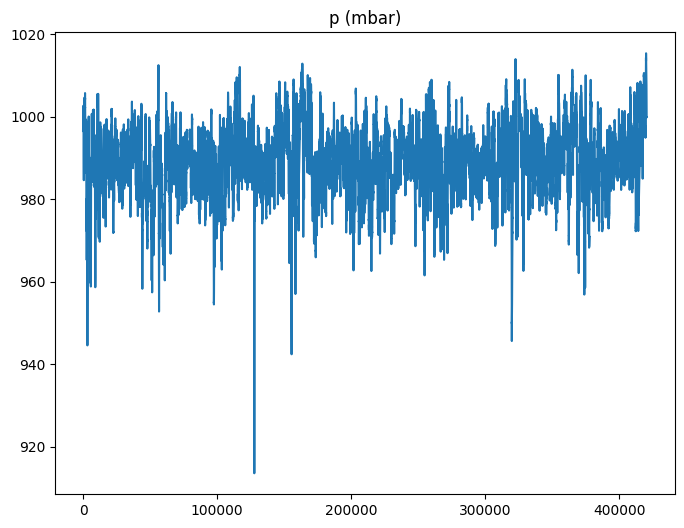

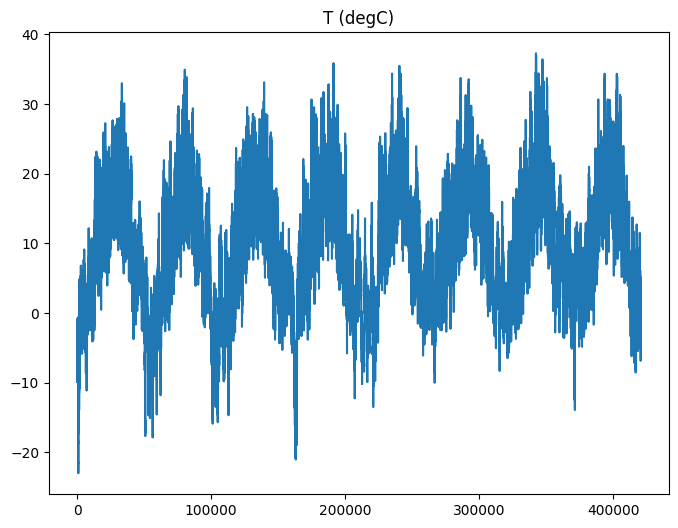

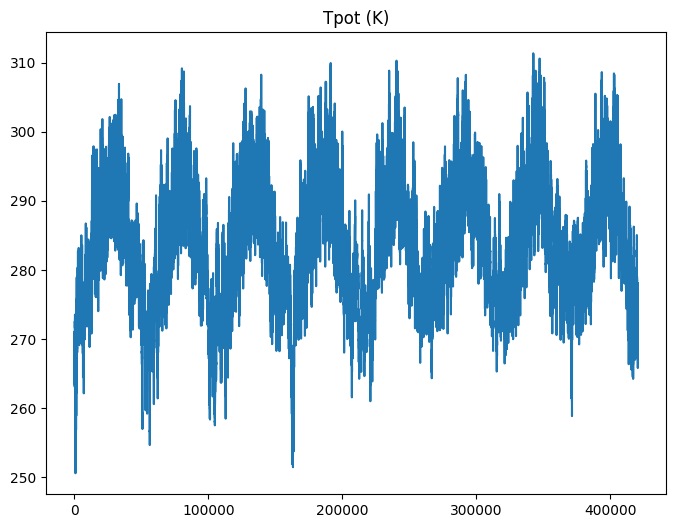

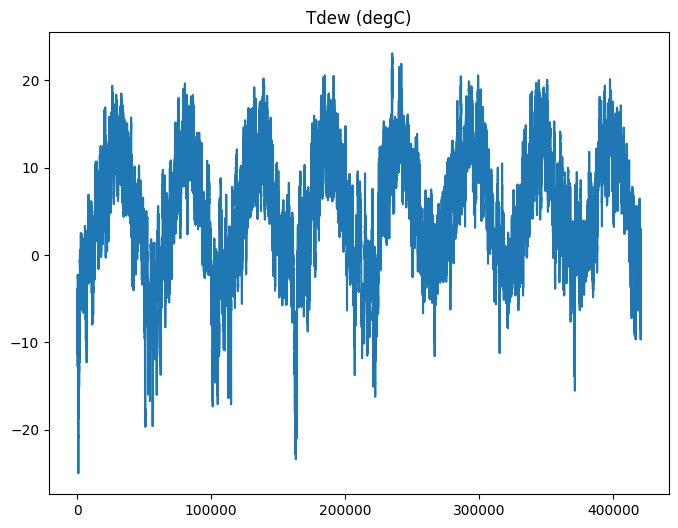

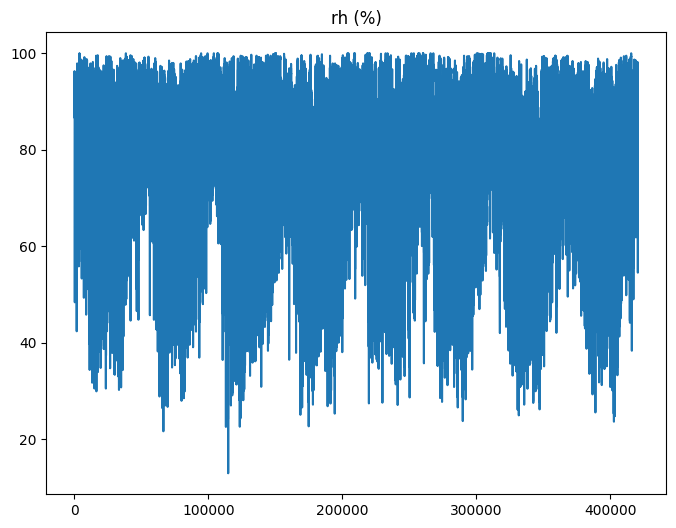

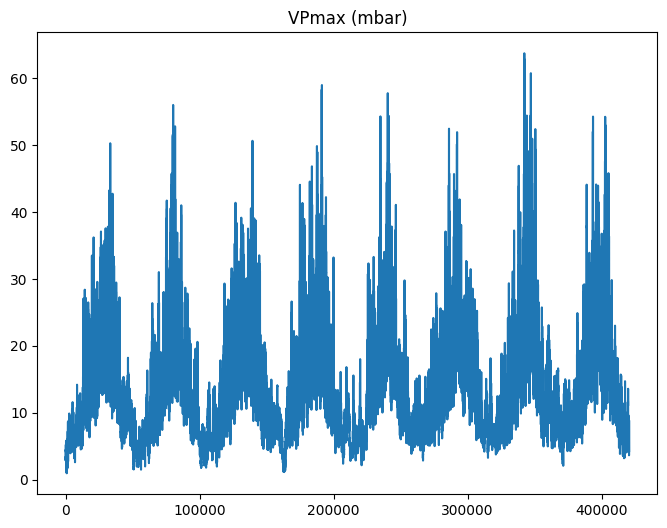

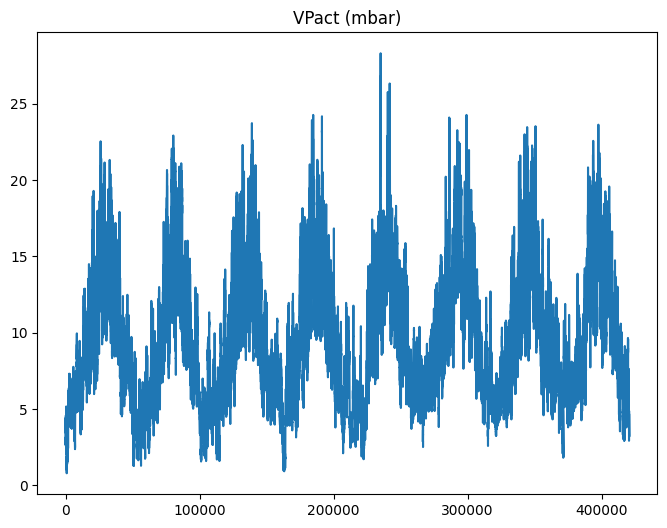

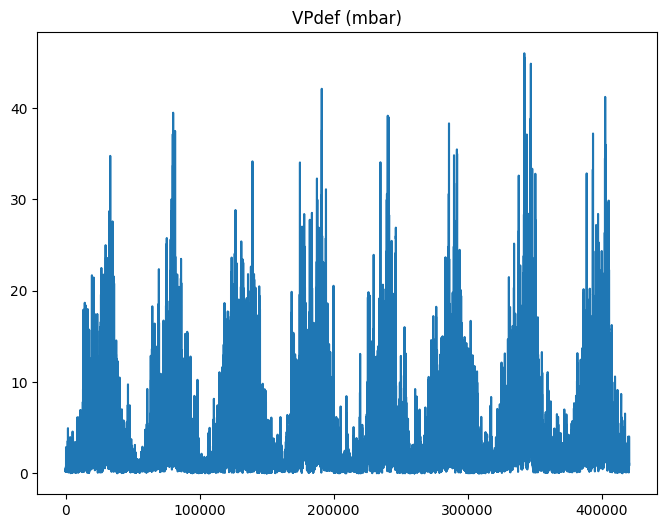

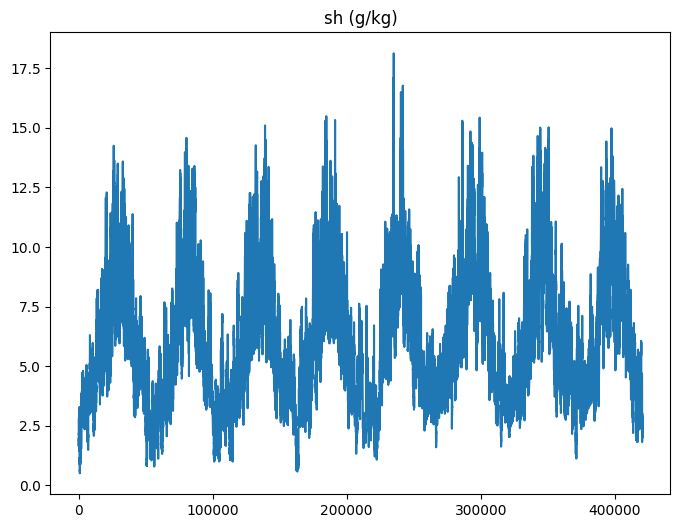

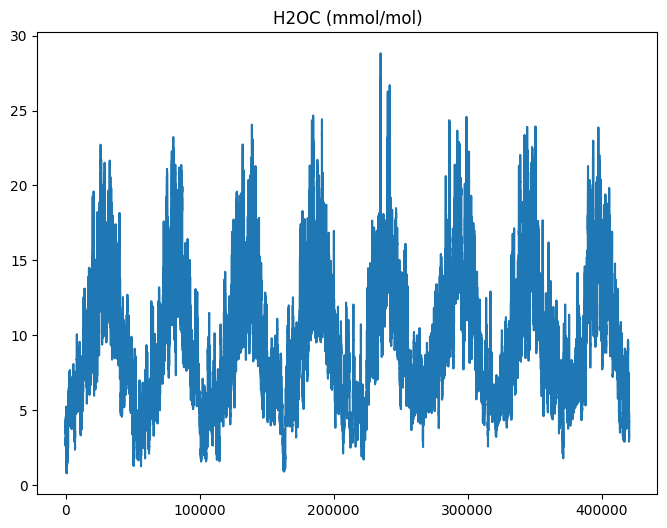

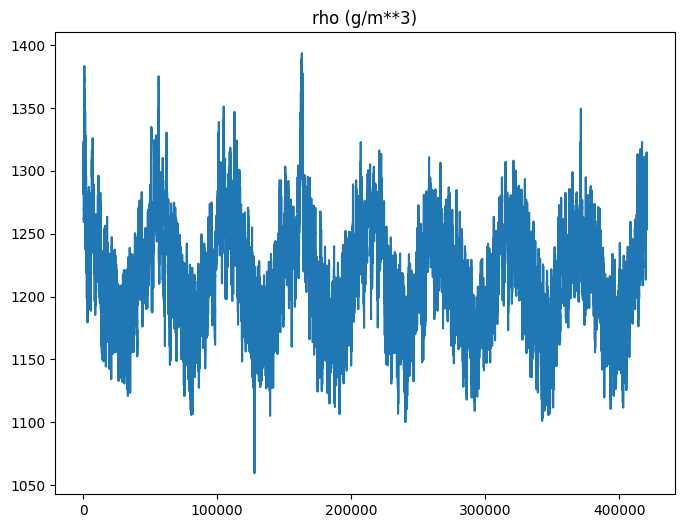

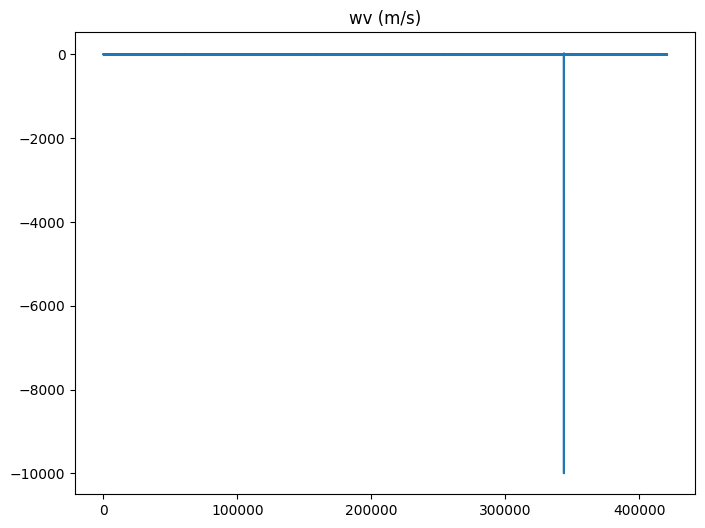

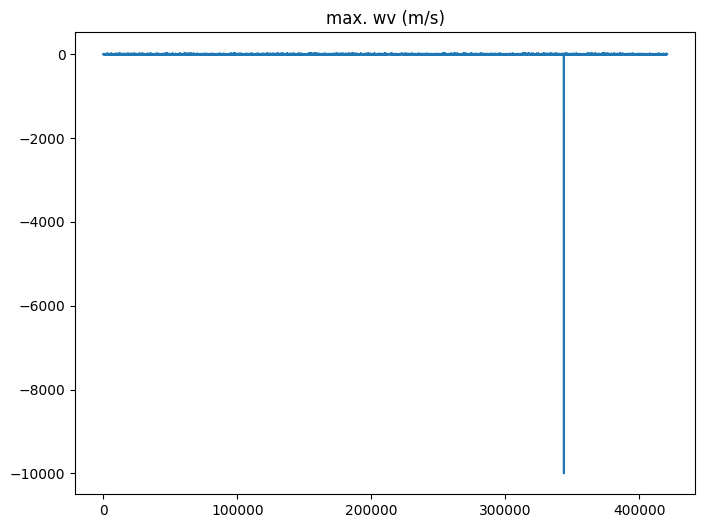

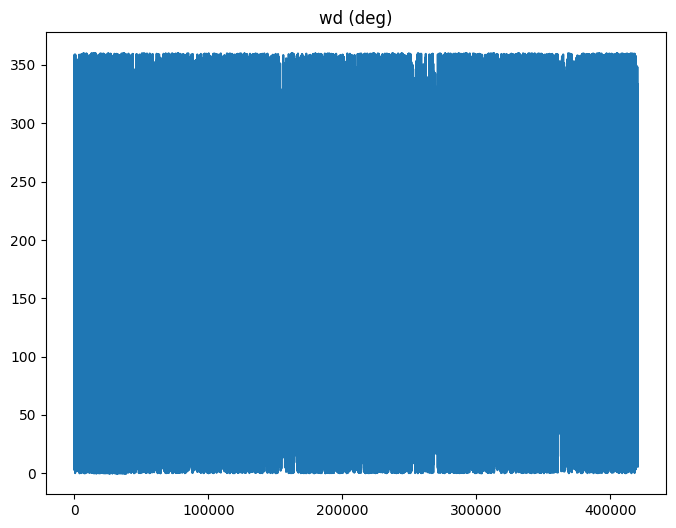

In [9]:
def show_raw_visualization(data):
    for key in data.keys():
        data[key].plot().set_title(f"{key}")
        plt.show()

show_raw_visualization(df)

Od razu można zauważyć nieprawidłowości związane z parametrami wiatru (ostatnie 3 grafiki). 'wv' i 'max. wv' pokazują siłę wiatru, a 'wd (deg)' kierunek wiatru to wartrości te powinny być niemniejsze od zera. 

In [10]:
df[df['wv (m/s)']<0]['wv (m/s)']

343578   -9999.0
343579   -9999.0
343580   -9999.0
343581   -9999.0
343582   -9999.0
343583   -9999.0
343584   -9999.0
343585   -9999.0
343586   -9999.0
343587   -9999.0
343588   -9999.0
343589   -9999.0
343590   -9999.0
343591   -9999.0
343592   -9999.0
343593   -9999.0
343594   -9999.0
343595   -9999.0
Name: wv (m/s), dtype: float64

In [11]:
df[df['max. wv (m/s)']<0]['max. wv (m/s)']

343577   -9999.0
343578   -9999.0
343579   -9999.0
343580   -9999.0
343581   -9999.0
343582   -9999.0
343583   -9999.0
343584   -9999.0
343585   -9999.0
343586   -9999.0
343587   -9999.0
343588   -9999.0
343589   -9999.0
343590   -9999.0
343591   -9999.0
343592   -9999.0
343593   -9999.0
343594   -9999.0
343595   -9999.0
343596   -9999.0
Name: max. wv (m/s), dtype: float64

Zastępujemy wartości ujemne zerami

In [12]:
df.loc[df['wv (m/s)'] == -9999.0, 'wv (m/s)'] = 0
df.loc[df['max. wv (m/s)'] == -9999.0, 'max. wv (m/s)'] = 0.0

/tmp/ipykernel_5200/4225408418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['wv (m/s)'] == -9999.0, 'wv (m/s)'] = 0
/tmp/ipykernel_5200/4225408418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['max. wv (m/s)'] == -9999.0, 'max. wv (m/s)'] = 0.0


Powyższy kod wypada poprawić.

In [13]:
#Popkzujemy brak błędnych wartości 
df[df['max. wv (m/s)']<0]['max. wv (m/s)']

Series([], Name: max. wv (m/s), dtype: float64)

I ponowna wizualizacja czy wszystko jest w porządku.

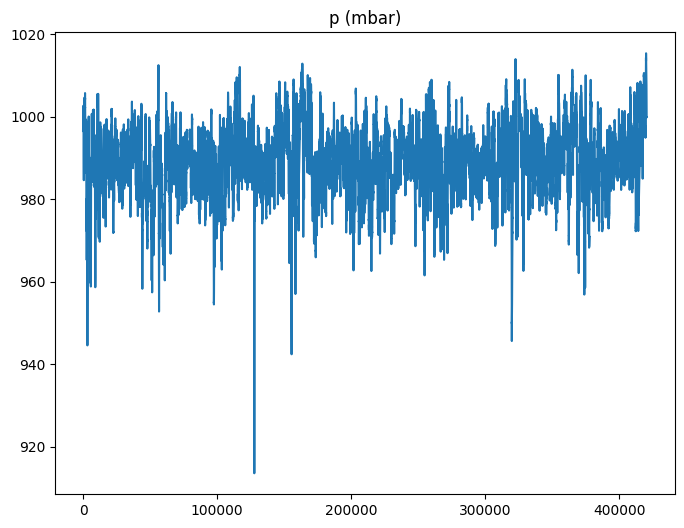

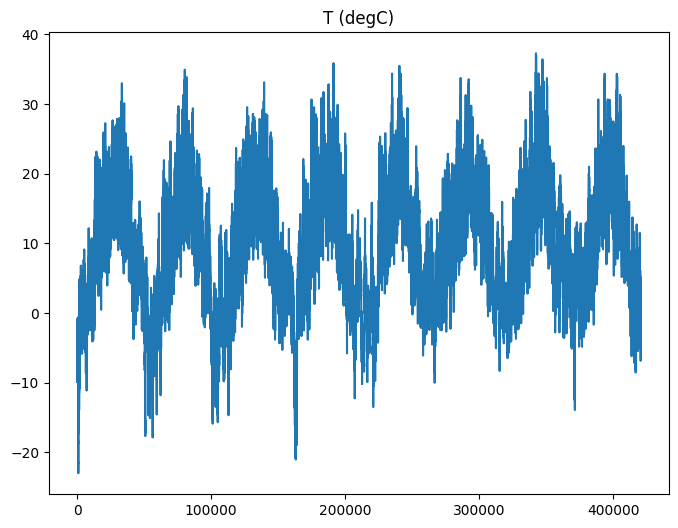

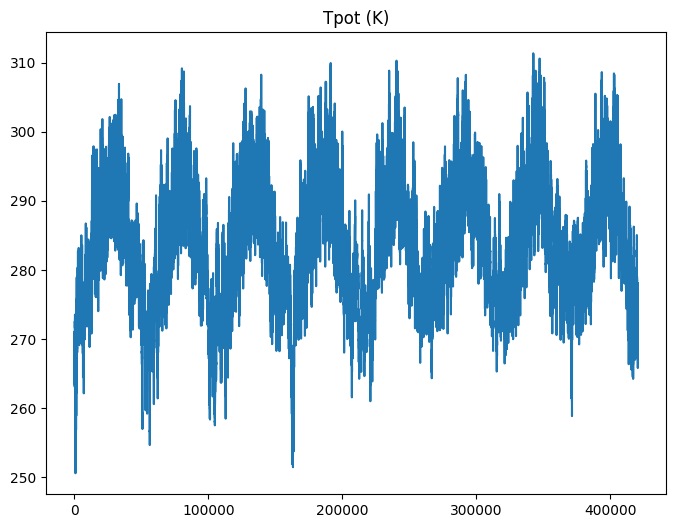

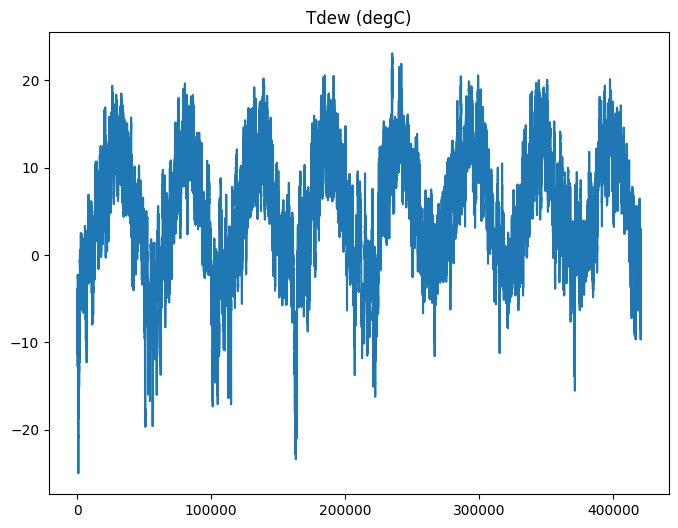

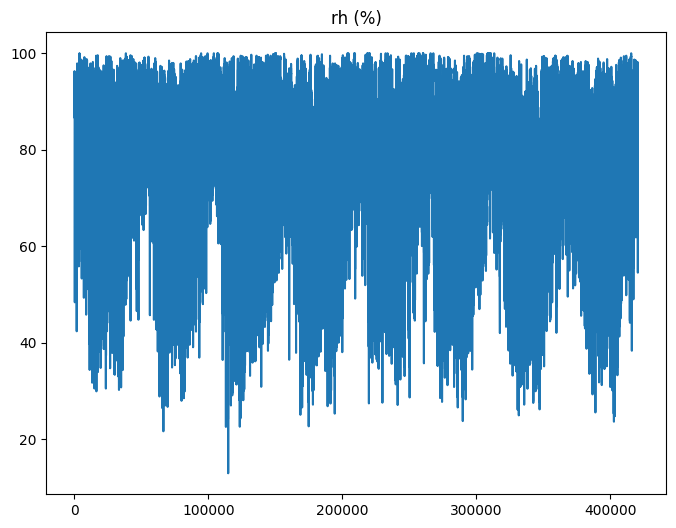

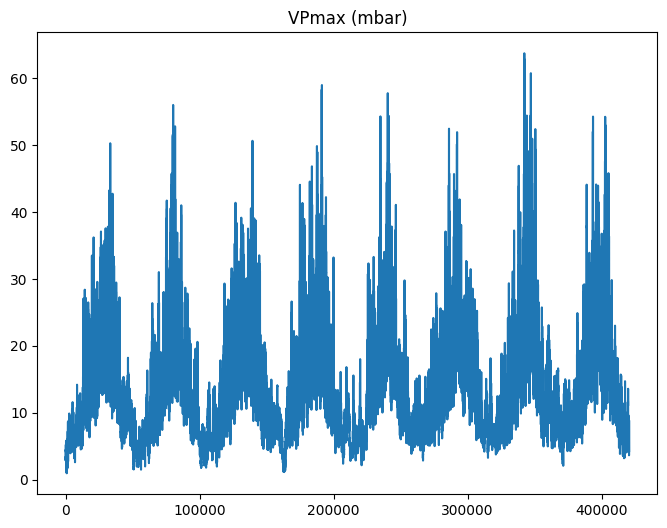

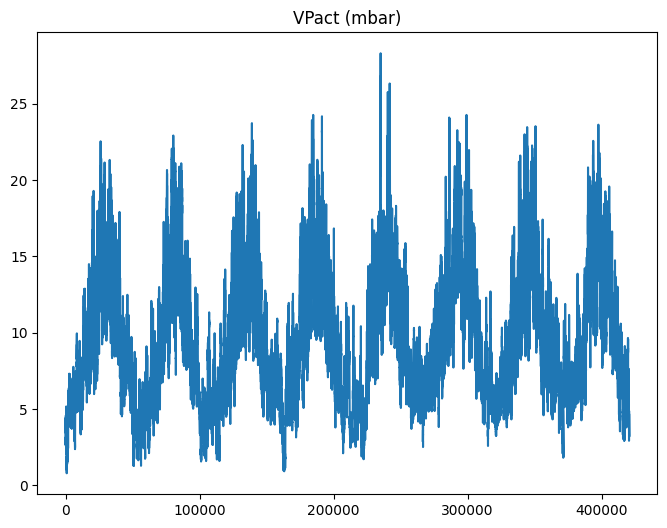

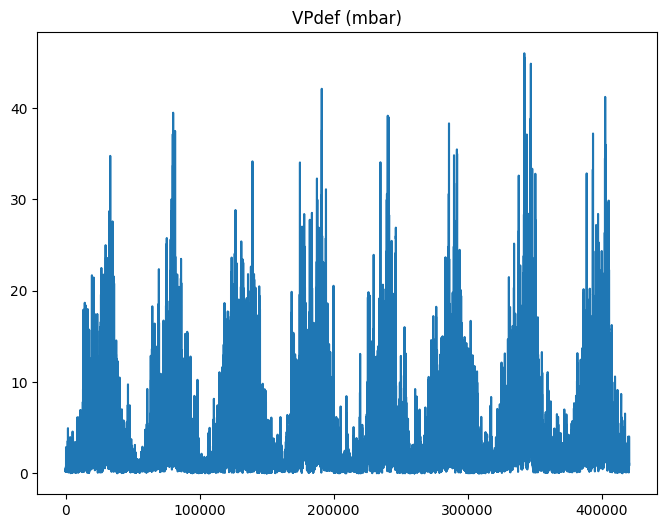

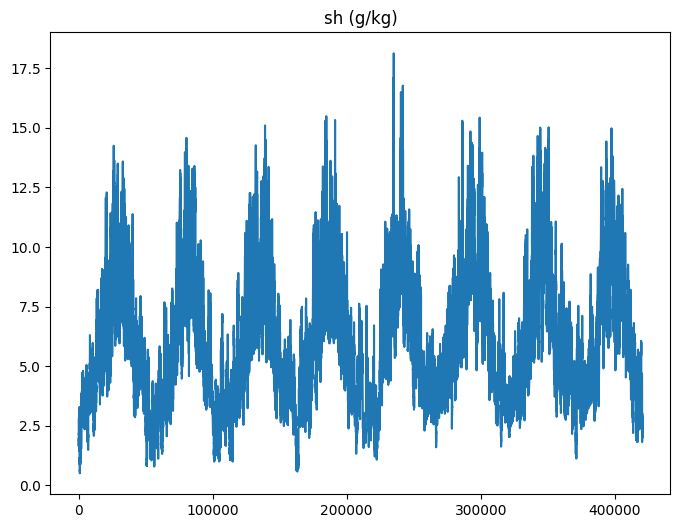

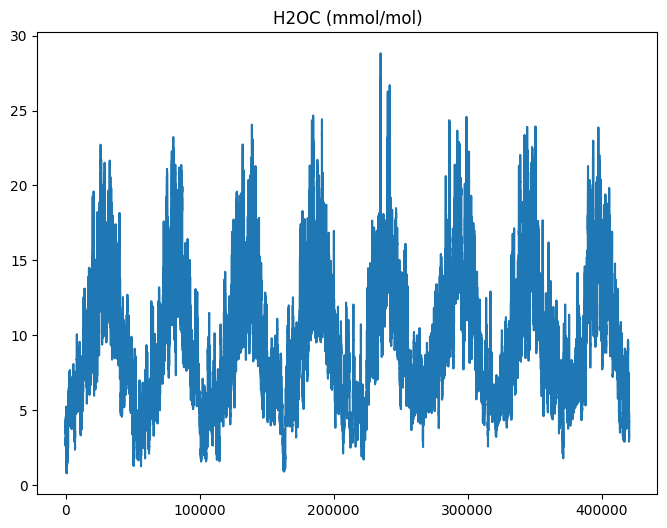

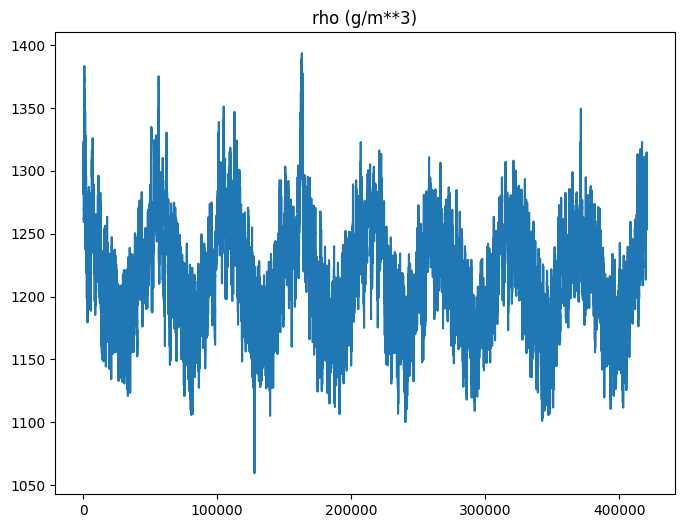

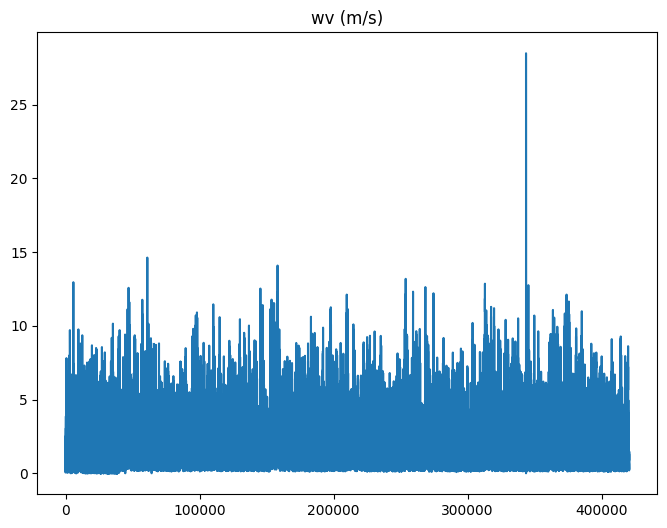

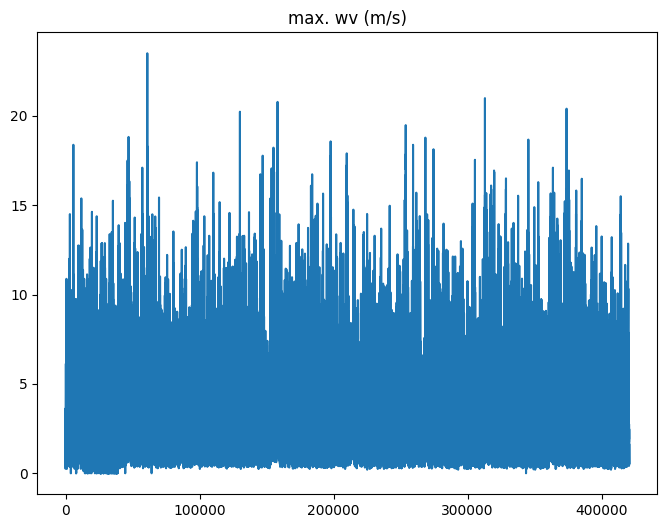

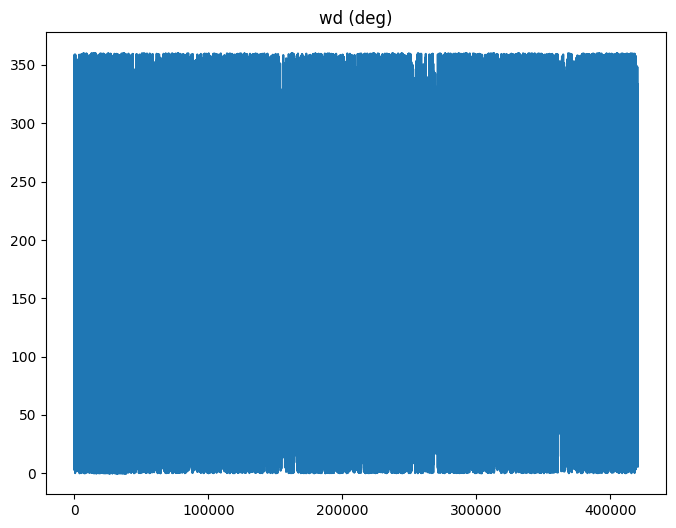

In [14]:
show_raw_visualization(df)

## Wstępne przetworzenie danych.

Zwróćmy uwagę, że parametr 'wd (deg)' jest w stopniach i wartości 0 deg i 359 deg powinny być blisko siebie. 

Text(0, 0.5, 'Wind Velocity [m/s]')

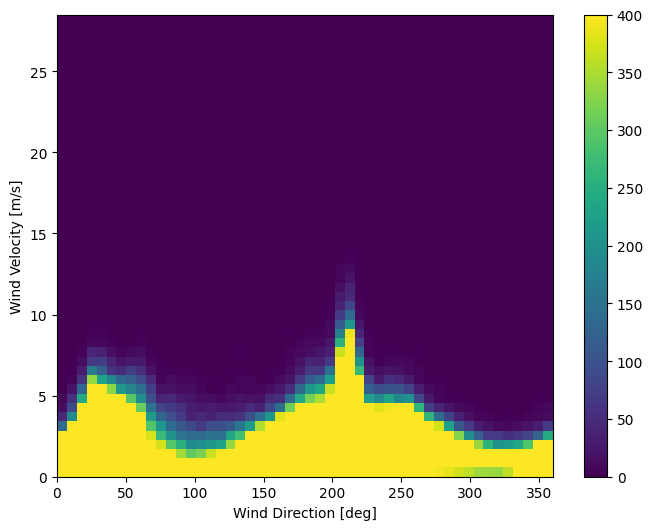

In [15]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Zmieńmy parametry wiatru na wektory. Taki zapis danych lepiej będzie oddawał stan faktyczny.

In [16]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

/tmp/ipykernel_5200/576055048.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Wx'] = wv*np.cos(wd_rad)
/tmp/ipykernel_5200/576055048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Wy'] = wv*np.sin(wd_rad)
/tmp/ipykernel_5200/576055048.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Powyższy kod wypada poprawić.

(-12.185637751588763,
 27.064703747937347,
 -8.898421828413506,
 7.849152333233395)

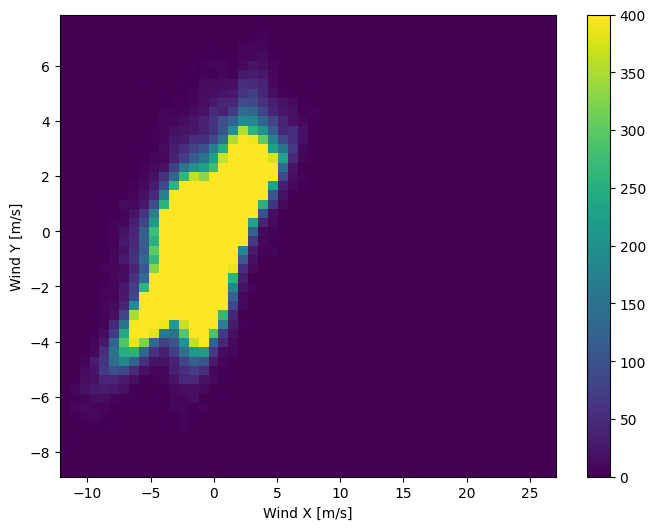

In [17]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Wprowadźmy zmienne oddające cykliczność dnia i nocy. 

In [18]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [19]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

/tmp/ipykernel_5200/913525465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
/tmp/ipykernel_5200/913525465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
/tmp/ipykernel_5200/913525465.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Powyższy kod wypada poprawić.

Text(0.5, 1.0, 'Time of day signal')

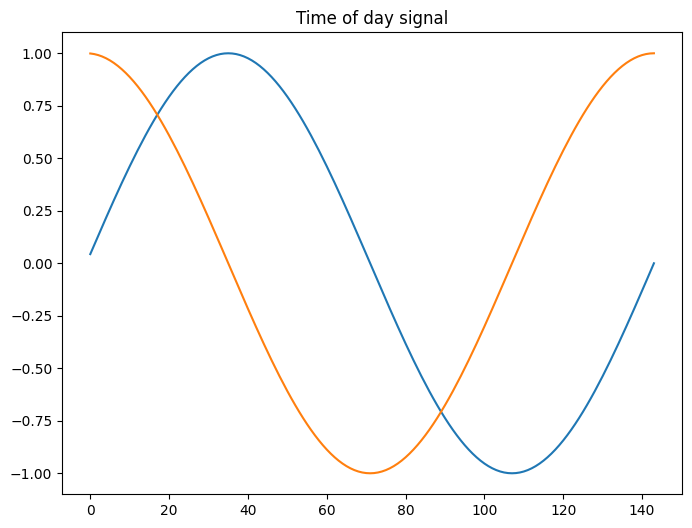

In [20]:
plt.plot(np.array(df['Day sin'])[:144])
plt.plot(np.array(df['Day cos'])[:144])
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

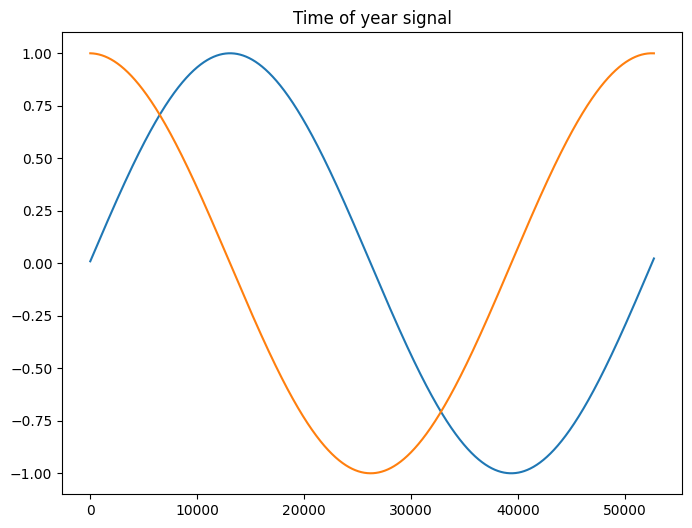

In [21]:
plt.plot(np.array(df['Year sin'])[:52704])
plt.plot(np.array(df['Year cos'])[:52704])
plt.title('Time of year signal')

Sprawdzamy korelacje między parametrami.

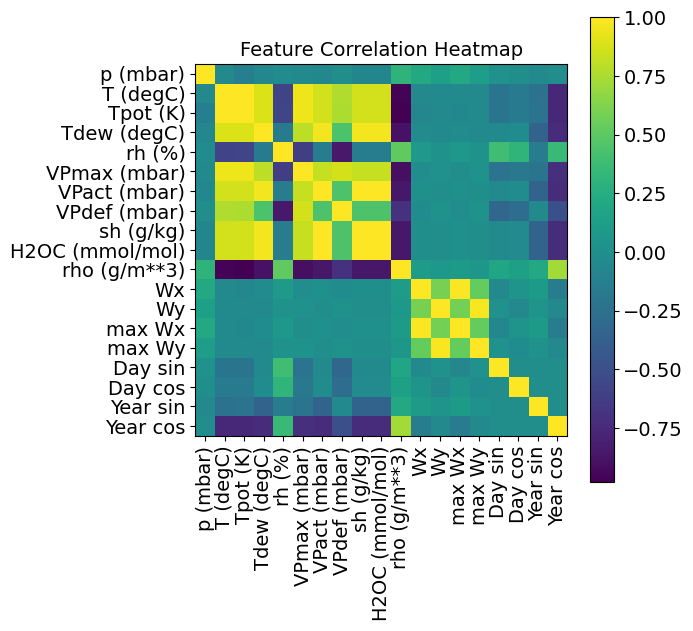

In [22]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

Widzimy, że hermetyczność (Airtight, rho g/m**3) jak i funkcja cos oddająca porę roku są odwrotnie skorelowane do parametrów związanych z ciśnieniem i temperaturą.  

## Budowa modelu 

In [23]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

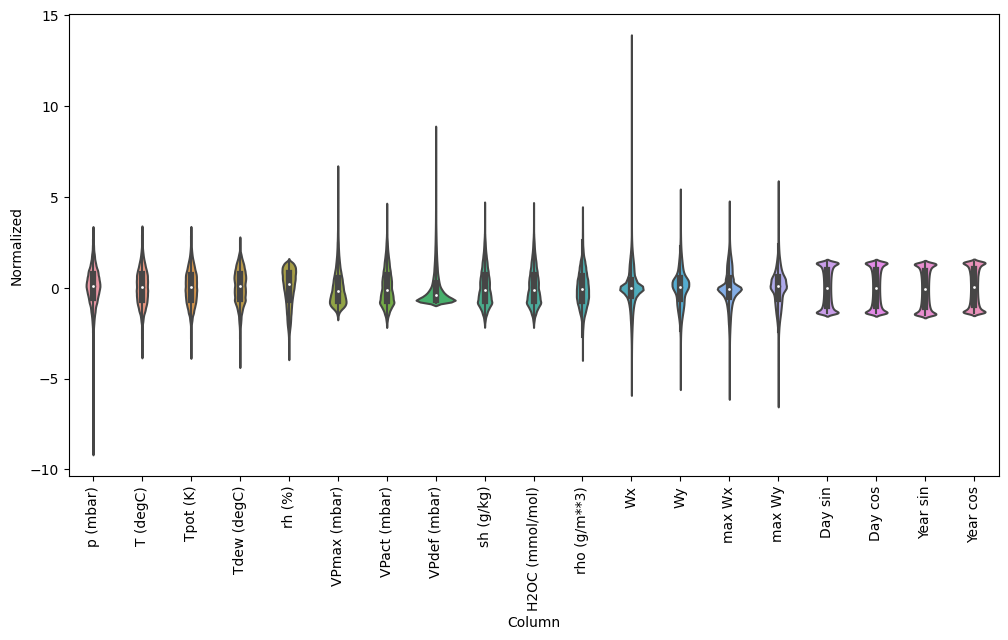

In [25]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [26]:
# Tutaj się zaczyna praca. Tworzymy 3 podziały, w1, w2 i w3, które różnią się ilością danych na wejściu wykorzystywanych przy dopasowywaniu parametrów naszych modeli 
# Ilość danych na wejściu z których będą korzystały nasze modele jest stały 
OUT_STEPS = 144
# Interesować nas będą następujące parametry pogodowe
label_out = ['p (mbar)', 'T (degC)', 'rh (%)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'Wx', 'Wy']
num_features = len(label_out)
# Z powyższych danych można policzyć wartości pozostałych parametrów. 

### Funkcje pomocnicze

In [27]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [29]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


In [30]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [31]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [32]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### Podziały

In [33]:
# Pierwszy podział będzie korzystał z danych z dnia poprzedzającego (144 wiersze)
w1 = WindowGenerator(input_width=144, label_width=OUT_STEPS, shift=OUT_STEPS,
                     label_columns=label_out)

### Modele dla 'w1'

W tym miejscu definiujemy mmodele oraz obliczamy je dla podziału w1.

In [34]:
multi_val_performance = {}
multi_performance = {}

#### Dense

Rozwinięta wersja modelu liniowego (przez dodanie tf.keras.layers.Dense między wejściem a wyjściem). Opiera się tylko na jednym wejściowym kroku czasowym.

In [35]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

2023-02-20 09:41:45.619424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 09:41:45.620217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-20 09:41:45.620326: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-20 09:41:45.620415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-20 09:41:45.620500: W tensorflow/c

In [36]:
history = compile_and_fit(multi_dense_model, w1)

Epoch 1/20
9184/9184 [==============================] - 114s 12ms/step - loss: 0.2703 - mean_absolute_error: 0.3462 - val_loss: 0.2708 - val_mean_absolute_error: 0.3459
Epoch 2/20
9184/9184 [==============================] - 114s 12ms/step - loss: 0.2569 - mean_absolute_error: 0.3355 - val_loss: 0.2702 - val_mean_absolute_error: 0.3453
Epoch 3/20
9184/9184 [==============================] - 113s 12ms/step - loss: 0.2526 - mean_absolute_error: 0.3324 - val_loss: 0.2712 - val_mean_absolute_error: 0.3453
Epoch 4/20
9184/9184 [==============================] - 113s 12ms/step - loss: 0.2498 - mean_absolute_error: 0.3304 - val_loss: 0.2731 - val_mean_absolute_error: 0.3473


2618/2618 [==============================] - 10s 4ms/step - loss: 0.2731 - mean_absolute_error: 0.3473


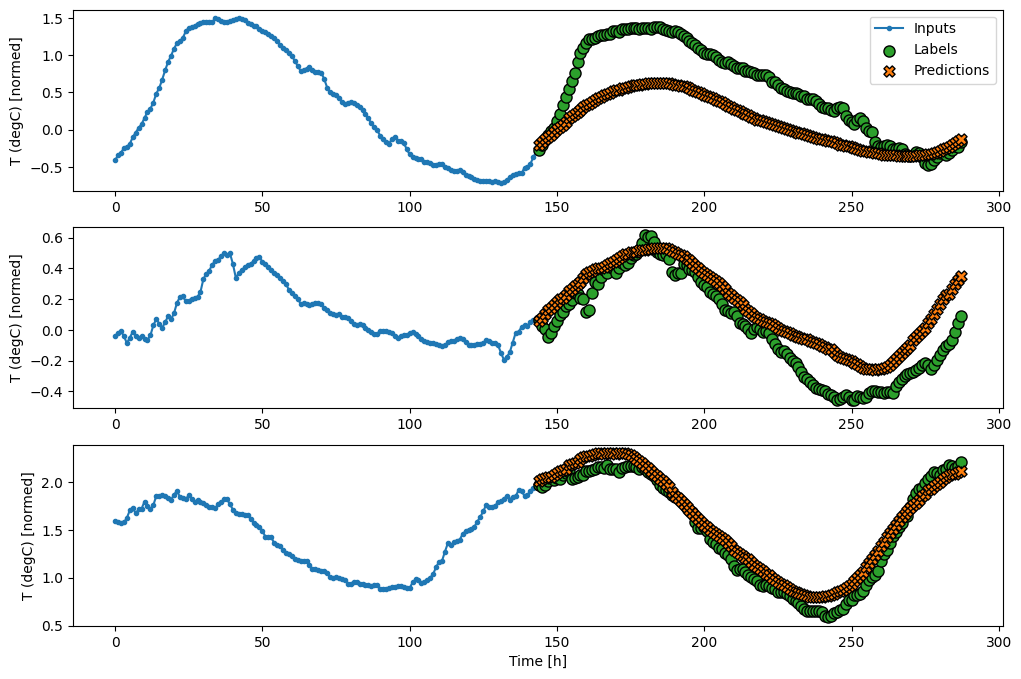

In [37]:
IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(w1.val)
multi_performance['Dense'] = multi_dense_model.evaluate(w1.test, verbose=0)
w1.plot(multi_dense_model)

#### CNN

Model splotowy tworzy prognozy na podstawie historii o stałej szerokości, co może prowadzić do lepszej wydajności niż model gęsty, ponieważ może zobaczyć, jak rzeczy zmieniają się w czasie.

In [38]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [39]:
history = compile_and_fit(multi_conv_model, w1)

Epoch 1/20
9184/9184 [==============================] - 73s 8ms/step - loss: 0.2720 - mean_absolute_error: 0.3492 - val_loss: 0.2687 - val_mean_absolute_error: 0.3448
Epoch 2/20
9184/9184 [==============================] - 72s 8ms/step - loss: 0.2591 - mean_absolute_error: 0.3387 - val_loss: 0.2665 - val_mean_absolute_error: 0.3433
Epoch 3/20
9184/9184 [==============================] - 72s 8ms/step - loss: 0.2555 - mean_absolute_error: 0.3358 - val_loss: 0.2647 - val_mean_absolute_error: 0.3418
Epoch 4/20
9184/9184 [==============================] - 77s 8ms/step - loss: 0.2534 - mean_absolute_error: 0.3342 - val_loss: 0.2662 - val_mean_absolute_error: 0.3440
Epoch 5/20
9184/9184 [==============================] - 88s 10ms/step - loss: 0.2519 - mean_absolute_error: 0.3333 - val_loss: 0.2665 - val_mean_absolute_error: 0.3431


2618/2618 [==============================] - 9s 3ms/step - loss: 0.2665 - mean_absolute_error: 0.3431


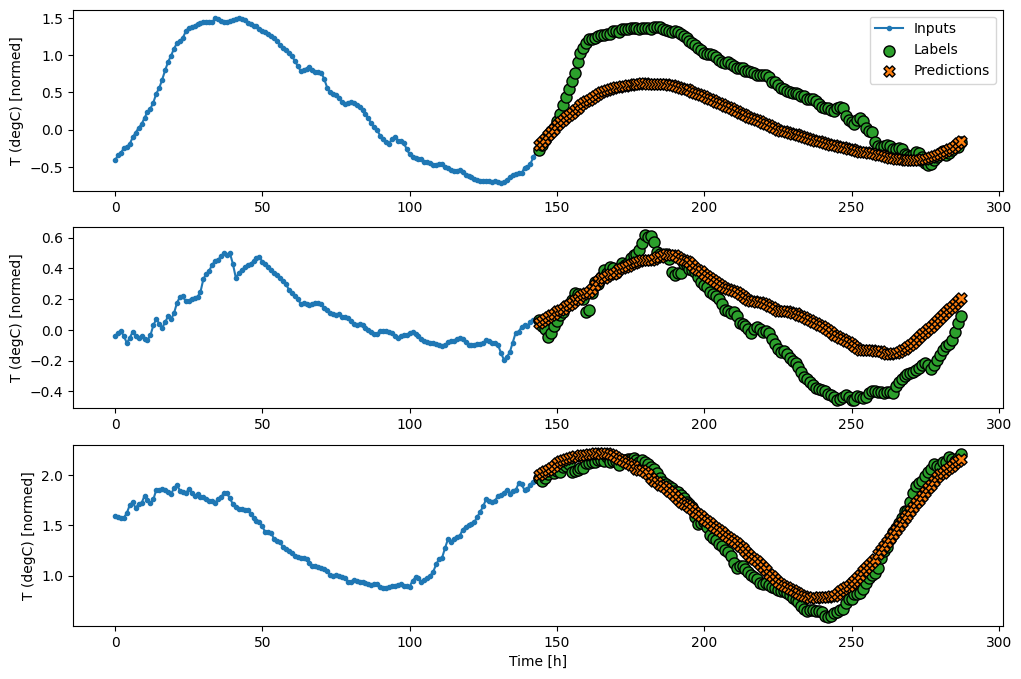

In [40]:
IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(w1.val)
multi_performance['Conv'] = multi_conv_model.evaluate(w1.test, verbose=0)
w1.plot(multi_conv_model)

#### RNN

Model cykliczny może nauczyć się korzystać z długiej historii danych wejściowych, jeśli jest to istotne dla prognoz, które wykonuje model. Akumuluje stan wewnętrzny przez 24 godziny, przed wykonaniem pojedynczej prognozy na następne 24 godziny.

In [41]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(multi_lstm_model, w1)

Epoch 1/20
9184/9184 [==============================] - 548s 59ms/step - loss: 0.2684 - mean_absolute_error: 0.3488 - val_loss: 0.2639 - val_mean_absolute_error: 0.3431
Epoch 2/20
1541/9184 [====>.........................] - ETA: 6:31 - loss: 0.2460 - mean_absolute_error: 0.3314

In [ ]:
IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(w1.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(w1.test, verbose=0)
w1.plot(multi_lstm_model)

W tym miejscu należy zaznaczyć, że powyższe modele można uzbroić w autoregresje. Tego typu modele mogą, lecz nie muszą, być bardziej dokładne. 
Zbadanie tego zagadnienia zostawiamy na niedaleką przyszłość. 

## Ocena Modelii 

W poniższych tabelach mamy uśredniony błąd w estymacji po wszystkich czasach i po wszystkich wartościach. 

Wartość błędu dla zbioru validacyjnego.

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Wartość błędu dla zbioru testowego.

In [ ]:
for name, value in multi_val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Na podstawie przedstawionego wykresu należy uznać za najdokładniejszy jest model rekurencyjnej sieci neuronowej. 

Jak już wcześniej wspominaliśmy rekurencyjny model pozwala na przechowywanie danych z wcześniejszych okresów i najlepiej oddaje cykliczność zdarzeń. 

Model splotow na pewno ma przewagę nad rekurencyjnym ze względu na znacznie krótszy czas obliczeń. Co więcej, różnica czasu między wykonaniem modelu splotowego, a gęstego nie jest tak duża, a dokładność jest większa. 

## Wdrożenie

Przedstawione badania pozwalają stwierdzić użyteczność prognozy pogody wykonaną przy użyciu sieci neuronowych na podstawie danych z jednej lokalizacji. Należy jednak zaznaczyć, że modele nie są wstanie przewidzieć dużych i nagłych zmian pogodowych ze względu na zbyt małą ilość dany. 